In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import math
import datetime


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
df = pd.read_csv('HistoricalQuotes.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,2020-02-28,$273.36,106721200,$257.26,$278.41,$256.37
1,2020-02-27,$273.52,80151380,$281.1,$286,$272.96
2,2020-02-26,$292.65,49678430,$286.53,$297.88,$286.5
3,2020-02-25,$288.08,57668360,$300.95,$302.53,$286.13
4,2020-02-24,$298.18,55548830,$297.26,$304.18,$289.23


In [5]:
price_columns = [' Close/Last', ' Open', ' High', ' Low']
for column in price_columns:
    df[column] = df[column].str.replace('$', '').astype(float)

In [6]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,2020-02-28,273.36,106721200,257.26,278.41,256.37
1,2020-02-27,273.52,80151380,281.10,286.00,272.96
2,2020-02-26,292.65,49678430,286.53,297.88,286.50
3,2020-02-25,288.08,57668360,300.95,302.53,286.13
4,2020-02-24,298.18,55548830,297.26,304.18,289.23


In [7]:
if df[' Volume'].dtype == 'object':
    df[' Volume'] = pd.to_numeric(df[' Volume'], errors='coerce')

In [8]:
df = df.sort_values('Date')

In [9]:
df.reset_index(drop=True, inplace=True)
print(df.index)

RangeIndex(start=0, stop=2518, step=1)


In [10]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,2010-03-01,29.8557,137312041,29.3928,29.9286,29.3500
1,2010-03-02,29.8357,141486282,29.9900,30.1186,29.6771
2,2010-03-03,29.9043,92846488,29.8486,29.9814,29.7057
3,2010-03-04,30.1014,89591907,29.8971,30.1314,29.8043
4,2010-03-05,31.2786,224647427,30.7057,31.3857,30.6614


In [11]:
features = [' Close/Last', ' Volume', ' Open', ' High', ' Low']
data = df[features].values

In [12]:
feature_range = (0, 1)
scaler = MinMaxScaler(feature_range=feature_range)
data_scaled = scaler.fit_transform(data)

In [13]:
pd.DataFrame(data_scaled, columns=features).head()

,Close/Last,Volume,Open,High,Low
0,0.000067,0.279219,0.000000,0.000000,0.003004
1,0.000000,0.288472,0.002022,0.000638,0.004113
2,0.000231,0.180643,0.001543,0.000177,0.004210
3,0.000894,0.173428,0.001707,0.000681,0.004544
4,0.004852,0.472832,0.004445,0.004891,0.007451


In [14]:
sequence_length = 60
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i + sequence_length])
    y.append(data_scaled[i + sequence_length, 0])
X = np.array(X)
y = np.array(y)

In [15]:
train_split = 0.8
split_idx = int(len(X) * train_split)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training set shape: X_train: (1966, 60, 5), y_train: (1966,)
Testing set shape: X_test: (492, 60, 5), y_test: (492,)


In [16]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

c:\Users\APEX\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [19]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0096 - val_loss: 0.0013
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.8857e-04 - val_loss: 3.8148e-04
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.9416e-04 - val_loss: 6.6375e-04
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.6741e-04 - val_loss: 5.1196e-04
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.5568e-04 - val_loss: 0.0011
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.9087e-04 - val_loss: 3.8666e-04
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.4868e-04 - val_loss: 5.4767e-04
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3.6866e-04 - val_loss: 9.1974e-04
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.5347e-04 - val_loss: 3.7526e-04
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.7104e-04 - val_loss: 8.7947e-04
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.1151e-04

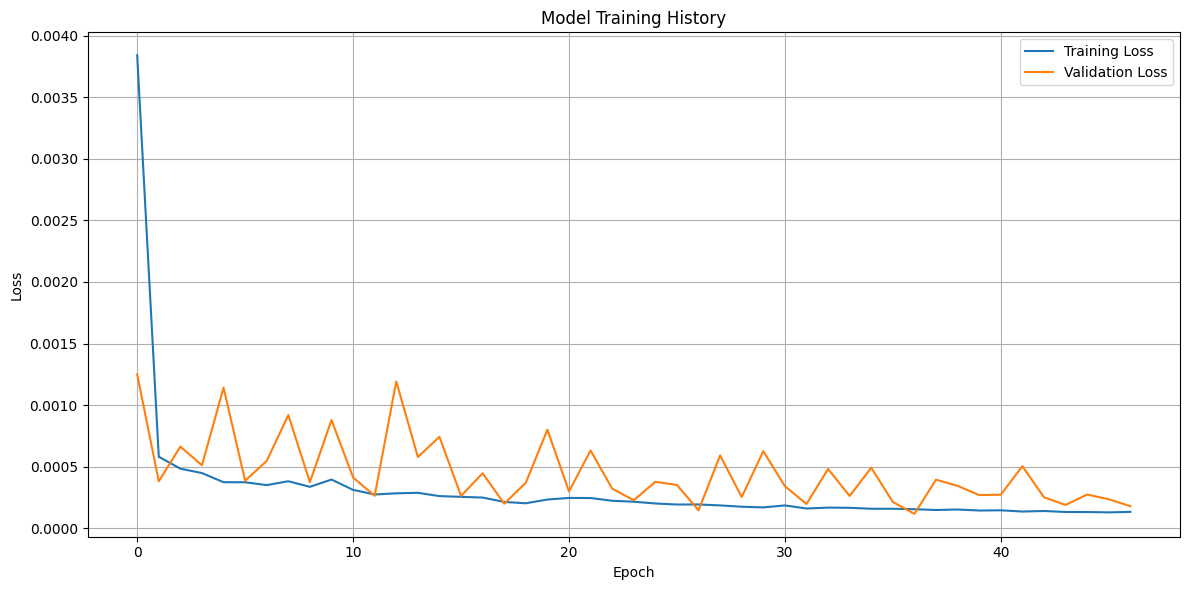

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [21]:
predictions = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [22]:
pred_reshape = np.zeros((len(predictions), scaler.scale_.shape[0]))
pred_reshape[:, 0] = predictions.flatten()
y_test_reshape = np.zeros((len(y_test), scaler.scale_.shape[0]))
y_test_reshape[:, 0] = y_test

In [23]:
predictions_actual = scaler.inverse_transform(pred_reshape)[:, 0]
y_test_actual = scaler.inverse_transform(y_test_reshape)[:, 0]

In [24]:
mse = mean_squared_error(y_test_actual, predictions_actual)
rmse = math.sqrt(mse)
r2 = r2_score(y_test_actual, predictions_actual)
normalized_rmse = rmse / (np.max(y_test_actual) - np.min(y_test_actual))
accuracy = max(0, (1 - normalized_rmse)) * 100

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Approximate Accuracy: {accuracy:.2f}%")

Mean Squared Error: 97.22
Root Mean Squared Error: 9.86
R² Score: 0.9445
Approximate Accuracy: 94.67%


In [26]:
dates = df['Date'].values

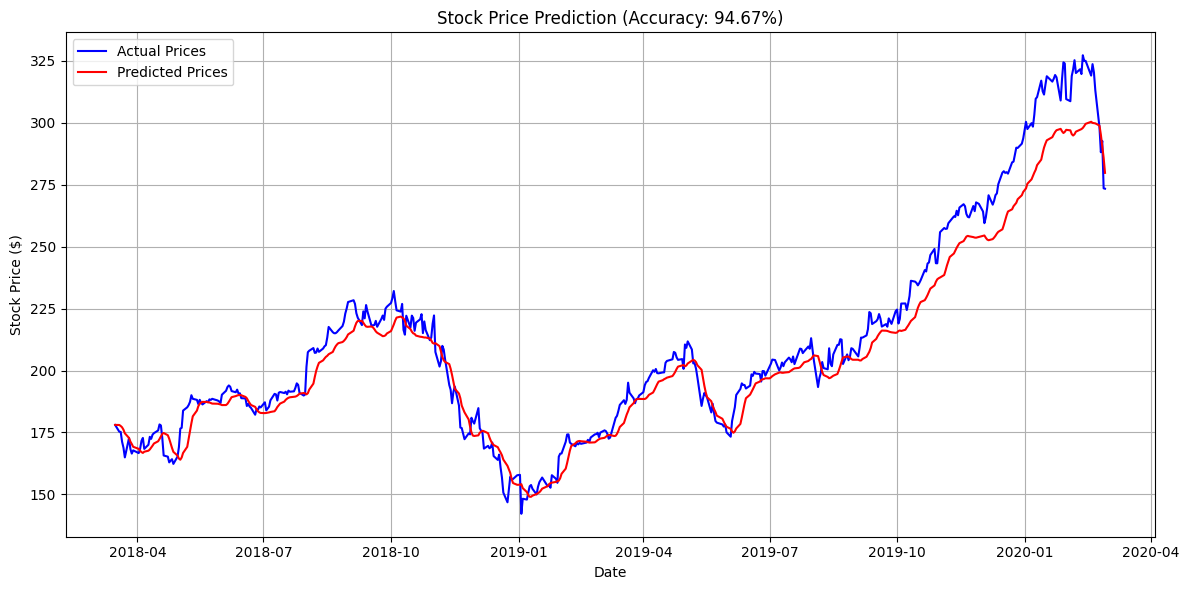

In [27]:
test_dates = dates[sequence_length + split_idx:sequence_length + len(y_test) + split_idx]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, label='Actual Prices', color='blue')
plt.plot(test_dates, predictions_actual, label='Predicted Prices', color='red')
plt.title(f'Stock Price Prediction (Accuracy: {accuracy:.2f}%)')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('stock_price_prediction.png')
plt.show()

In [28]:
last_sequence = X[-1:].copy()
next_day_prediction = model.predict(last_sequence)
next_day_reshape = np.zeros((1, scaler.scale_.shape[0]))
next_day_reshape[0, 0] = next_day_prediction[0, 0]
next_day_price = scaler.inverse_transform(next_day_reshape)[0, 0]
print(f"Predicted price for the next day: ${next_day_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted price for the next day: $279.75
